In [1]:
import pandas as pd
import numpy as np
import os
from random import random
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.layers.merge import concatenate
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate
from keras import optimizers
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import f1_score


from imblearn.over_sampling import SMOTE

print("done")

done


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#load DATA
#change dir to correct location
dataDir = r'D:/EE5821/FinalProjectData/LD_DATA/' 
# configure the angles to load into dataset
anglesToConvert = ["10","15","20","25","30","35","40","45","50"]
# configure difficulties to load into dataset
ranksToClass = ["0","1","2","3","4","5","6","7","8"]
#ranksToClass = ["0","1","2","3","4","5","6","7"]
#anglesToConvert = ["10","15","20"]
numOverride = 0

def create_dataset():
    
    errorCount = 0
    
    img_data_array=[]
    angle_array=[]
    class_name=[]
    noMatch_array = []
    
    for angle in anglesToConvert:
        print("angle", angle)
        img_template_location = dataDir + 'DataTemplate' + angle + 'Degrees.csv'
        imageTemplate = pd.read_csv(img_template_location,encoding='latin1')
        imageTemplate = imageTemplate.dropna()
        imageTemplate = imageTemplate.drop_duplicates()
        
        img_folder = dataDir + angle + 'Degrees_Cropped'
        
        numberOfImages = imageTemplate.shape[0]
        if(numOverride != 0 ):
            numberOfImages = numOverride
            
        for i in range(1,(numberOfImages+1)):
            #print(imageTemplate.loc[(i-1),"File Name"])
            #imagePath = img_folder + '\CropData-(' + str(i) + ').png'
            imagePath = img_folder + '\\' + imageTemplate.loc[(i-1),"File Name"] +'.png'
            ranking = imageTemplate.loc[(i-1),"Rating"]
            #image = Image.open(imagePath)
            
            noMatch = imageTemplate.loc[(i-1),"NoMatching"]
            
            image = cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)
            #downsample image
            scale_percent = 10 # percent of original size
            #scale_percent = 100
            width = int(image.shape[1] * scale_percent / 100)
            height = int(image.shape[0] * scale_percent / 100)
            dim = (width, height)
            resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            resized = resized[:,:,::-1]
            
            if( (ranking != "ERROR") ):
                img_data_array.append(resized)
                class_name.append(ranking)
                angle_array.append(angle)
                noMatch_array.append(noMatch)
            else:
                errorCount = errorCount + 1
    print("Errors: " + str(errorCount))
    return img_data_array, class_name, angle_array, noMatch_array


In [4]:
def normalized_angle_array(angle_array, noMatch_array):

    #normalize angle
    normailized_angle_array = [float(x) / 50 for x in angle_array]

    #combine data
    combinedTextData = pd.DataFrame()
    #combinedTextData[0] = angle_array
    combinedTextData[0] = normailized_angle_array
    combinedTextData[1] = noMatch_array
    #print(combinedTextData.loc[14])
    #provide random number
    
    
    return combinedTextData


In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

def eqSampling(test_data, combinedTextData, class_name, sampleType):

    #convert to numpy array
    test_data = np.asarray(test_data)
    class_name = np.asarray(class_name)
    combinedTextData = np.asarray(combinedTextData)
    
    # ---------------------------------
    # Do Undersampling of data
    # ---------------------------------

    # get shape of array
    numEle, height, width, rgb = test_data.shape

    #flatten image
    flat_test_data = test_data.reshape(numEle,height*width*rgb)

    #combine data
    combinedData = np.append(flat_test_data, combinedTextData,1)


    print(combinedData.shape)

    # choose correction type
    if sampleType == "SMOTE":
        sampled = SMOTE()
    else:
        sampled = NearMiss()

        
    x_nr, y_nr = sampled.fit_resample(combinedData, class_name)

    #get shape
    newNumEle, columns = x_nr.shape

    newTextData = pd.DataFrame()
    newTextData[0] = x_nr[:,(columns-2)]
    newTextData[1] = x_nr[:,(columns-1)]

    newTextData = np.asarray(newTextData)



    x_nr = np.delete(x_nr, [columns-2,columns-1], axis=1)


    x_nr = x_nr.reshape(newNumEle,height,width,rgb)

    x_nr = np.asarray(x_nr)

    
    return x_nr, newTextData, y_nr

In [36]:

def splitData(testData, combinedTextData, class_name, randomNumber = -1):    
    
    if randomNumber == -1:
        randomNumber = int(random() * 100)
    #randomNumber = 96
    x_trainImage, x_testImage, y_train, y_test = train_test_split(testData, class_name, test_size=0.1, random_state=randomNumber, stratify = class_name)                                               
    x_trainData, x_testData, y_train2, y_test2 = train_test_split(combinedTextData, class_name, test_size=0.1, random_state=randomNumber, stratify = class_name)                                                            


    #print(x_nr.shape)
    #print(y_nr.shape)

    class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y =  y_train)
    class_weights = dict(enumerate(class_weights))
    
    
    x_trainImage = x_trainImage.astype('float32')
    x_testImage = x_testImage.astype('float32')
    x_trainData = x_trainData.astype('float32')
    x_testData = x_testData.astype('float32')
    x_trainImage /= 255
    x_testImage /= 255

    
    return x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, randomNumber


In [7]:
#graph data
from collections import Counter
from collections import OrderedDict

def printDataMetrics(class_name, y_train, y_test):

    Total = Counter(class_name)
    
    Total = OrderedDict(sorted(Total.items()))
    print(Total)
    Test = Counter(y_test)
    Test = OrderedDict(sorted(Test.items()))
    Train = Counter(y_train)
    Train = OrderedDict(sorted(Train.items()))

    
    plt.subplots(1)
    plt.bar(list(Total.keys()),list(Total.values()))
    plt.xlabel("Difficulty")
    plt.ylabel("Number of elements")
    plt.title("Total Dataset by Difficulty")

    plt.subplots(1)
    plt.bar(list(Test.keys()),list(Test.values()))
    plt.xlabel("Difficulty")
    plt.ylabel("Number of elements")
    plt.title("Test Dataset by Difficulty")

    plt.subplots(1)
    plt.bar(list(Train.keys()),list(Train.values()))
    plt.xlabel("Difficulty")
    plt.ylabel("Number of elements")
    plt.title("Train Dataset by Difficulty")



In [8]:

def getInputShape(x_trainImage):
    
    img_rows = x_trainImage.shape[1]
    img_cols = x_trainImage.shape[2]
    input_shape = (img_rows, img_cols, 3)
    
    return input_shape

#print(x_trainImage[1][50])
#plt.imshow(x_trainImage[73])




In [9]:
def toCategorical(y_train, y_test, num_category):
    

    y_train = keras.utils.to_categorical(y_train, num_category)
    y_test = keras.utils.to_categorical(y_test, num_category)
    #y_train[0]#print the label of the 1st training element
    return y_train, y_test

In [10]:
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate, Input

def CreateModel1(convolve1, convolve2, hiddenlayers, input_shape):
    
# --------------------------------------------
# Set up convolution side 
# --------------------------------------------
    num_category = 9
    # input 
    inputsConvolve = Input(shape=input_shape)
    # convolution with 9 filers and size of 5x5
    x = Conv2D(convolve1, kernel_size=(3, 3), activation='relu', padding='same')(inputsConvolve)
    # max pool of 2x2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # two convolutions, one 18 filter, and a 36 filter 3x3 and 5x5 respectfully.
    #x = Conv2D(18, (3, 3), activation='sigmoid',padding='same')(x)
    x = Conv2D(convolve2, (5, 5), activation='relu', padding='same')(x)
    # Do a dropout
    x = Dropout(0.25)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # flatten instert into a 20 node hidden layer
    x = Flatten()(x)
    x = Dense(num_category, activation='relu')(x)
    #x = Dense(10, activation='relu')(x)
    
    #x = Dropout(0.5)(x)
    x = Dense((num_category*2), activation='relu')(x)
    x = Dense(num_category, activation = 'softmax')(x)
    convolvModel = Model(inputsConvolve, x)
    
    # ----------------------------------------------
    # set up angle side
    # ----------------------------------------------
    inputsData = Input(shape = (2))
    #y = Dense(num_category*2, activation = 'relu')(inputsData)
    y = Dense(num_category, activation = 'softmax')(inputsData)
    #y = Dense(num_category, activation = 'softmax')(y)
    #y = Dense(1, activation = 'linear')(y)
    dataModel = Model(inputsData, y)
    
    # ----------------------------------------------
    # combine models 
    # ----------------------------------------------
    combined = concatenate([convolvModel.output, dataModel.output])
    
    final = Dense(hiddenlayers, activation='relu')(combined)
    final = Dense(num_category, activation = 'softmax')(final)
    #final = Dense(1, activation = 'linear')(combined)
    
    model = Model(inputs = [convolvModel.input, dataModel.input], outputs=final)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              #optimizer= keras.optimizers.Adam(learning_rate=0.001,
              #                                  beta_1=0.9,
              #                                  beta_2=0.999,
              #                                  epsilon=1e-07,
              #                                  amsgrad=True,
              #                                  name='Adam'
              #                              ),
              metrics=['accuracy']
              #metrics=['top_k_categorical_accuracy'],           
              )
    return model

In [11]:
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate, Input

def CreateModel2(convolve1, convolve2, hiddenlayers, input_shape):
    num_category = 9
# --------------------------------------------
# Set up convolution side 
# --------------------------------------------
    
    # input 
    inputsConvolve = Input(shape=input_shape)
    # convolution with 9 filers and size of 5x5
    x = Conv2D(convolve1, kernel_size=(3, 3), activation='relu', padding='same')(inputsConvolve)
    # max pool of 2x2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # two convolutions, one 18 filter, and a 36 filter 3x3 and 5x5 respectfully.
    #x = Conv2D(18, (3, 3), activation='sigmoid',padding='same')(x)
    x = Conv2D(convolve2, (5, 5), activation='relu', padding='same')(x)
    # Do a dropout
    x = Dropout(0.25)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # flatten and insert into a 20 node hidden layer
    x = Flatten()(x)
    #x = Dense(num_category, activation='relu')(x)
    #x = Dense(10, activation='relu')(x)
    
    x = Dense((num_category*4), activation='relu')(x)
    x = Dense(num_category, activation = 'softmax')(x)
    convolvModel = Model(inputsConvolve, x)
    
    # ----------------------------------------------
    # set up angle side
    # ----------------------------------------------
    inputsData = Input(shape = (2))
    #y = Dense(num_category*2, activation = 'relu')(inputsData)
    #y = Dense(2, activation = 'relu')(inputsData)
    #y = Dense(num_category, activation = 'softmax')(y)
    #y = Dense(1, activation = 'linear')(y)
    #dataModel = Model(inputsData, y)
    
    # ----------------------------------------------
    # combine models 
    # ----------------------------------------------
    combined = concatenate([convolvModel.output, inputsData])
    
    
    
    #final = Dense(48, activation ='relu')(combined)
    final = Dense(hiddenlayers, activation = 'relu' )(combined)
    #final = Dense(18, activation = 'relu' )(final)
    final = Dense(num_category, activation = 'softmax')(final)
    #final = Dense(1, activation = 'linear')(combined)
    
    model = Model(inputs = [convolvModel.input, inputsData], outputs=final)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              #optimizer= keras.optimizers.Adam(learning_rate=0.001,
              #                                  beta_1=0.9,
              #                                  beta_2=0.999,
              #                                  epsilon=1e-07,
              #                                  amsgrad=True,
              #                                  name='Adam'
              #                              ),
              metrics=['accuracy']
              #metrics=['top_k_categorical_accuracy'],           
              )
    return model

In [33]:
# ---------------------
# Flags
# ---------------------
imbalancedLearning = 1
dataeqType = "SMOTE"
verbose = 1

# ----------------------------
# Run full preModel
# -----------------------------
def runPremodel(test_data, class_name, angle_array, noMatch_array, imbalancedLearning, dataeqType, verbose, seed = -1):
    if verbose == 1:
        print("combining Data")
    combinedTextData = normalized_angle_array(angle_array, noMatch_array)


    

    old_class_name = np.asarray(class_name)
    new_testData = np.asarray(test_data)
    new_class_name = np.asarray(class_name)
    new_combinedTextData = np.asarray(combinedTextData)

    if verbose == 1:
        print("Spliting data:")
        print(new_testData.shape)
        print(new_class_name.shape)
        print(new_combinedTextData.shape)

        
    #split into training and test data
    x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, randomNumber = splitData(new_testData, new_combinedTextData, new_class_name, seed)

    
    
    if imbalancedLearning == 1:
        if verbose == 1:
            print("Doing imbalanced spliting")
        
        #over/under sample training data
        x_trainImage, x_trainData, y_train = eqSampling(x_trainImage, x_trainData, y_train, dataeqType)    
    
    if verbose == 1:
        printDataMetrics(old_class_name, y_train, y_test)
        print("Getting Shape")
    
    input_shape = getInputShape(x_trainImage)

    num_category = 9

    if verbose == 1:
        print("Convert classes to categorical")
    
    #convert to categorical
    y_train, y_test = toCategorical(y_train, y_test, num_category)

    if verbose == 1:
    #print data
        print("Class Weights: ")
        print(class_weights)
        print('x_trainImage shape: ' + str(x_trainImage.shape))
        print('x_trainData shape: ' + str(x_trainData.shape))
        print('y_train shape: ' + str(y_train.shape))
        print('x_testImage shape: ' + str(x_testImage.shape))
        print('x_testData shape: ' + str(x_testData.shape))
        print('y_test shape: ' + str(y_test.shape))

        #show sample image to verify
        print("image 73")
        print('ranking: ')
        print(y_train[73])
        print('angle: ' + str(x_trainData[73][0]) + '  matching:  ' + str(x_trainData[73][1]))
        plt.subplots(1)
        plt.imshow(x_trainImage[73])

    return x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, input_shape, randomNumber


In [13]:
#Save the model
# serialize model to JSON
def saveModel(model):
    model_digit_json = model.to_json()
    with open("model_digit.json", "w") as json_file:
        json_file.write(model_digit_json)
     #serialize weights to HDF5
    model.save_weights("model_digit.h5")
    print("Saved model to disk")

In [14]:
def offByOneEvaluate(model, test_data, test_class):
    
   
    
    y_predicWeights =  model.predict(test_data)
    y_predic = np.argmax(y_predicWeights, axis = -1)
    y_true = np.argmax(test_class, axis =-1)
    
    
    sumOf = 0
    for i in range(0,len(y_predic)):
        #print(str(y_predic[i]) + str(y_true[i]))
        if (y_predic[i] == y_true[i]) or (y_predic[i] == (y_true[i]-1)) or (y_predic[i] == (y_true[i]+1)):
            
            sumOf = sumOf + 1
        
    
    #print('sum '+ str(sumOf))
    #print('total ' + str(len(y_predic)))
    OffByOneAccuracy = float(sumOf) / float(len(y_predic))
    return OffByOneAccuracy



In [41]:
#Option for loading model back in
def loadModel(modelDir):

    with open((modelDir + 'model_digit.json'), 'r') as json_file:
        json_savedModel= json_file.read()
    #load the model architecture 
    model_j = tf.keras.models.model_from_json(json_savedModel)
    #model_j.summary()


    model_j.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer="adam",
                  metrics=['accuracy']
                  #metrics=['top_k_categorical_accuracy'],           
                  )
    
    model_j.load_weights((modelDir + 'model_digit.h5'))
    
    return model_j

In [22]:
#load Dataset
test_data, class_name, angle_array, noMatch_array = create_dataset()

angle 10
angle 15
angle 20
angle 25
angle 30
angle 35
angle 40
angle 45
angle 50
Errors: 5


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

## automated machine learning
imbalancedLearning = [0]
#imbalancedLearning = [1]
dataeqType = ["SMOTE"]
#dataeqType = ["SMOTE"]
batch_size_array = [50,100]
#batch_size_array = [50]
#repeats = 1
repeats = 15
model_array = [1,2]
#model_array = [2]

firstConvolveArray = [64]
secondConvolveArray = [128]
hiddenLayerArray = [12,18,24]
#hiddenLayerArray = [24]

#firstConvolveArray = [64]
#secondConvolveArray = [128]
#hiddenLayerArray = [12]

num_epoch = 50
verbose = 0
mode = 0o777

#change to DIR needed 
modelDir = r'D:/EE5821/FinalProjectData/ModelImages/'
f = open(modelDir + 'Summary.txt', "w")

start = time.time()
for iteration in range(0,repeats):
    for imb in imbalancedLearning:
        for eq in dataeqType:
            
            # get and split up data
            x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, input_shape, randomNumber = runPremodel(test_data, class_name, angle_array, noMatch_array, imb, eq, verbose)
            
            for batch_size in batch_size_array:
                for modelNum in model_array:                   
                    for conv1 in firstConvolveArray:
                        for conv2 in secondConvolveArray:
                            for hiddenLayer in hiddenLayerArray:
                    
                                if imb == 0:
                                    dirName = r'Model' + str(modelNum) + '_Batch' + str(batch_size) + '_weighted' + '_iteration' + str(iteration) + '_Convolves' + str(conv1) + '_' + str(conv2) + '_hiddenLayers' + str(hiddenLayer)
                                else:
                                    dirName = r'Model' + str(modelNum) + '_Batch' + str(batch_size) + '_Imblearn' + eq + '_iteration' + str(iteration) + '_Convolves' + str(conv1) +'_' + str(conv2) + '_hiddenLayers' + str(hiddenLayer)

                                os.mkdir((modelDir + dirName), mode)

                                if modelNum == 1:
                                    model = CreateModel1(conv1, conv2, hiddenLayer, input_shape)
                                elif modelNum == 2:
                                    model = CreateModel2(conv1, conv2, hiddenLayer, input_shape)

                                # fit model NOTE: imbalanced learn does not need weights for training
                                print("Fitting Model:")
                                print(dirName)
                                if imb == 1:
                                    model_log = model.fit([x_trainImage, x_trainData], 
                                              y_train,
                                              batch_size=batch_size,
                                              epochs=num_epoch,
                                              verbose=0,
                                              validation_split=0.1,
                                              shuffle=1)
                                else:
                                    
                                    model_log = model.fit([x_trainImage, x_trainData], 
                                              y_train,
                                              batch_size=batch_size,
                                              epochs=num_epoch,
                                              verbose=0,
                                              validation_split=0.1,
                                              class_weight= class_weights,
                                              shuffle=1)
                                    
                                

                                #plot and save accuracy model
                                plt.plot(model_log.history['accuracy'])
                                plt.plot(model_log.history['val_accuracy'])
                                plt.ylabel('Accuracy')
                                plt.xlabel('Epoch')
                                plt.legend(['Training', 'Validation'])
                                plt.grid()
                                #save then clear
                                plt.savefig(modelDir + dirName + '/AccuracyCurve.png')
                                plt.clf()

                                #plot and save loss model
                                plt.plot(model_log.history['loss'])
                                plt.plot(model_log.history['val_loss'])
                                plt.title('model loss')
                                plt.ylabel('loss')
                                plt.xlabel('epoch')
                                plt.legend(['train', 'validation'], loc='upper right')
                                #save then clear
                                plt.savefig(modelDir + dirName + '/lossCurve.png')
                                plt.clf()
                                
                                # create and save confusion matrix
                                y_predicWeights = model.predict([x_testImage,x_testData] )
                                y_predic = np.argmax(y_predicWeights, axis = -1)
                                y_true = np.argmax(y_test, axis =-1)
                                cm = confusion_matrix(y_true, y_predic)
                                cm = confusion_matrix(y_true, y_predic)

                                cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

                                cm_display.plot()
                                plt.savefig(modelDir + dirName + '/ConfusionMatrix.png')
                                plt.clf()
                                
                                # evaluate and print summary to text document
                                score = model.evaluate([x_testImage,x_testData], y_test, verbose=0)
                                offByOneScore = offByOneEvaluate(model, [x_testImage,x_testData], y_test)
                                
                                
                                print('\t Test loss:' + str(score[0]) + '\n')
                                print('\t Train/Test Split Seed: ' + str(randomNumber) + '\n')
                                print('\t Test accuracy:' + str(score[1]) + '\n')
                                print('\t F1 score: ' + str(f1_score(y_true, y_predic, average='weighted' )) + '\n')
                                
                                f.write(dirName + '\n')
                                f.write('\t Train/Test Split Seed:' + str(randomNumber) + '\n')
                                f.write('\t Test loss:' + str(score[0]) + '\n')
                                f.write('\t Test accuracy:' + str(score[1]) + '\n')
                                f.write('\t Off By One Test accuracy:' + str(offByOneScore) + '\n')
                                f.write('\t F1 score: ' + str(f1_score(y_true, y_predic, average='weighted' )) + '\n')
                                f.write('\t F1 score: ' + str(f1_score(y_true, y_predic, average=None )) + '\n')
                                #save to csv for better formatting
                                endData = pd.DataFrame()
                                endData.insert(0, "accuracy", model_log.history['accuracy'], True)
                                endData.insert(1, "val_accuracy", model_log.history['val_accuracy'], True)
                                endData.insert(2, "loss", model_log.history['loss'] , True)
                                endData.insert(3, "val_loss", model_log.history['val_loss'], True)
                                endData.to_csv((modelDir + dirName + '/modelData.csv'))
                                
                                #save model
                                model_digit_json = model.to_json()
                                with open((modelDir + dirName + '/model_digit.json'), "w") as json_file:
                                    json_file.write(model_digit_json)
                                 #serialize weights to HDF5
                                model.save_weights(modelDir + dirName + '/model_digit.h5')
                                
                                
                                f.flush()

end = time.time()

f.write(str(end-start))     

f.close()

In [ ]:
#model training single 

batch_size = 100
num_epoch = 100
x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, input_shape = runPremodel(test_data, class_name, angle_array, noMatch_array, 0, "SMOTE", 1)

model = CreateModel1(64,128,24,input_shape)

#model = model_j
#model.load_weights('Golden_model_digit.h5')

model_log = model.fit([x_trainImage, x_trainData], 
                      y_train,
                      batch_size=batch_size,
                      epochs=num_epoch,
                      verbose=1,
#                      validation_data=([x_testImage,x_testData], y_test))
                      validation_split=0.1,
                      class_weight= class_weights,
                      shuffle=1)



In [ ]:
#plot accuracy curve
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()




#how well did it do? 
score = model.evaluate([x_testImage,x_testData], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



In [ ]:
## confusion matrix of previous model
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics


seed = 96
x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, input_shape, randomNumber = runPremodel(test_data, class_name, angle_array, noMatch_array, 0, "SMOTE", 1, seed)

model = 0
#change to model if needed 
model = loadModel('D:\EE5821\BestModel\Model1_Batch100_weighted_iteration1_Convolves64_128_hiddenLayers24\\')
    
y_predicWeights = model.predict([x_testImage,x_testData] )

y_predic = np.argmax(y_predicWeights, axis = -1)
y_true = np.argmax(y_test, axis =-1)

#print(y_predic)
#print(y_true)
cm = confusion_matrix(y_true, y_predic)
#print(confusion)


cm = confusion_matrix(y_true, y_predic)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'])

cm_display.plot()
plt.show()

print('f1 score: ' + str(f1_score(y_true, y_predic, average=None)))




In [31]:
#show summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 117, 107, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 117, 107, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 58, 53, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 53, 128)  204928      max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
import os
import csv
# plotting the metrics
#fig = plt.figure()
#plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.close()
#plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.tight_layout()

endData = pd.DataFrame()
endData.insert(0, "accuracy", model_log.history['accuracy'], True)
endData.insert(1, "val_accuracy", model_log.history['val_accuracy'], True)
endData.insert(2, "loss", model_log.history['loss'] , True)
endData.insert(3, "val_loss", model_log.history['val_loss'], True)
endData.to_csv("Test.csv")
#with open('Names.csv', 'w') as csvfile:
#    writer = csv.DictWriter(csvfile, fieldnames = ['accuracy', 'val_accuracy', 'loss', 'val_loss'])
#    writer.writeheader()
#    writer.writerows(model_log.history)

In [ ]:
x_trainImage, x_trainData, y_train, x_testImage, x_testData, y_test, class_weights, input_shape, randomNumber = runPremodel(test_data, class_name, angle_array, noMatch_array, 0, "SMOTE", 1)

model = 0
model = loadModel('D:\EE5821\Best Model\Model2_Batch100_ImblearnSMOTE_iteration0_Convolves64_128_hiddenLayers24\\')
score = model.evaluate([x_testImage,x_testData], y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy: ', score[1])
print('Off By One Accuracy: ' + str(offByOneEvaluate(model, [x_testImage,x_testData], y_test)))

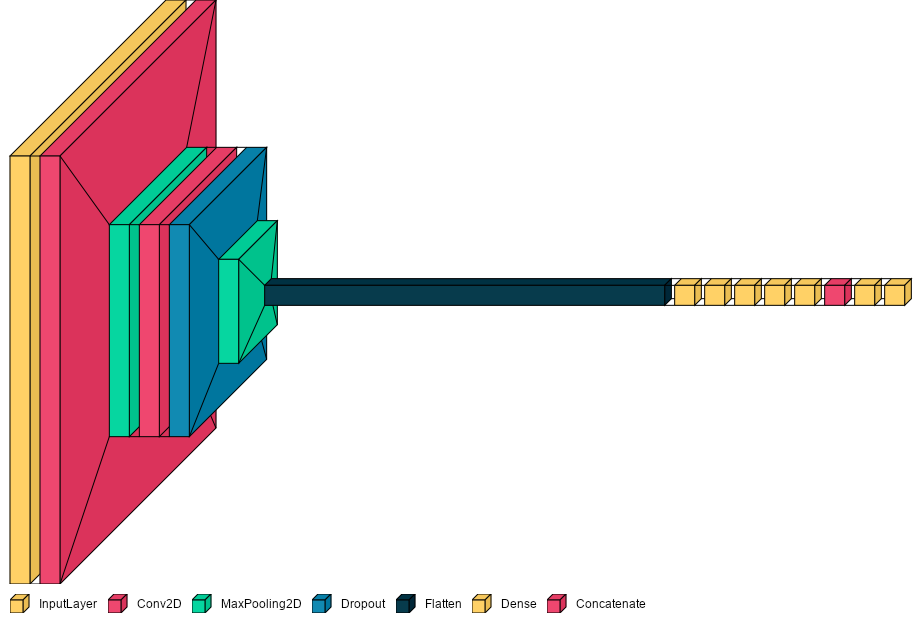

In [19]:
#visualize model

import visualkeras
from keras.utils.vis_utils import plot_model
from PIL import ImageFont

bestModelDir = "D:\EE5821\BestModel\Model1_Batch100_weighted_iteration1_Convolves64_128_hiddenLayers24\\"
#bestModelDir = "D:\EE5821\Best Model_BAD_SMOTE_TESTDATA\Model2_Batch100_ImblearnSMOTE_iteration0_Convolves64_128_hiddenLayers24\\"
font = ImageFont.truetype("arial.ttf", 12)

model = loadModel(bestModelDir)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model, legend=True, font=font) 
